# Numerical Optimization HW3 (1013)
## Multivariate Optimization
### 20211108 Donghyuk Jung  
Multivariate Optimization : Nelder - Mead method and Powell's method in this notebook, we will optimize three functions

$f(x,y)=(x+2y-6)^2+(2x+y-6)^2\\$
$f(x,y)=50(y-x^2)^2+(1-x)^2\\$
$f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$

---
# Implementation

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.tri as tri 
import math as m
import time as t
from tabulate import tabulate

### Define Function

In [8]:
def f_1(p=(0,0),x=0,y=0) : 
    x,y=p
    return (x+2*y-6)**2+(2*x+y-6)**2 
def f_2(p=(0,0),x=0,y=0) :
    x,y=p
    return 50*(y-x**2)**2+(1-x)**2 
def f_3(p=(0,0),x=0,y=0) :
    x,y=p
    return (1.5-x+x*y)*2+(2.25-x+x*(y**2))**2+(2.625-x+x*(y**3))**2

### Define Plotting Function

In [19]:

def plotContour(f, rangeX=(0, 0), rangeY=(0, 0), grid=(0, 0)): 
    x = np.arange(*rangeX, 0.01)
    y = np.arange(*rangeY, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f((X, Y)) 
    plt.figure(figsize=grid)
    
    cp = plt.contour(X, Y, Z, levels=np.linspace(
    Z.reshape(-1, 1).min(), Z.reshape(-1, 1).max(), 40), linewidths=0.2)
    plt.colorbar(cp)

def plotPoly(x1, x2, x3):
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], color="red", linewidth=.8) 
    plt.plot([x2[0], x3[0]], [x2[1], x3[1]], color="red", linewidth=.8) 
    plt.plot([x3[0], x1[0]], [x3[1], x1[1]], color="red", linewidth=.8)
def plotLine(x1, x2):
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], color="green", linewidth=.8)
def plotPoint(x):
    plt.plot([x[0]], [x[1]], marker='o', markersize=4, color="blue") 
    plt.text(x[0]+.03, x[1]+.03, "(%.3f, %.3f)" % x, fontsize=20)
def resultsInTable(simp, f, terminationMode=1):
    n1, n2, n3, n4 = NelderMeadMethod(simp, f, terminationMode)
    p1, p2, p3, p4 = PowellMethod(Point(*simp[0]), f, terminationMode) 
    print(tabulate([["NelderMeadMethod", n1, n2, n3, n4], ["PowellMethod", p1, p2, p3, p4]],headers=["minimum", "point", "iteration", "time"], floatfmt=".5f")) 
    return

### For convenience of calculation, define point class

In [10]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)

    def __rmul__(self, other):
        x = self.x * other
        y = self.y * other
        return Point(x, y)

    def __truediv__(self, other):
        x = self.x / other
        y = self.y / other
        return Point(x, y)

    def size(self):
        return m.sqrt(self.x**2+self.y**2)

    def e(self):
        return (self.x, self.y)


### 1. Nelder-Mead Method

In [24]:
def NelderMeadMethod(x, f, terminationMode, alpha=1, beta=0.5, gamma=2):
    start = t.time()
    x1, x2, x3 = Point(*x[0]), Point(*x[1]), Point(*x[2])
    plotPoly(x1.e(), x2.e(), x3.e())
    cnt = 0
    M = 10
    while True:
        c = (x1+x2)/2
        # 1. Sort
        fx = [[x1, f(x1.e())], [x2, f(x2.e())], [x3, f(x3.e())]]
        fx.sort(key=lambda x: x[1])
        x1, x2, x3 = fx[0][0], fx[1][0], fx[2][0]
        f1, f2, f3 = fx[0][1], fx[1][1], fx[2][1]
        c = (x2 + x1)/2  # centroid
        xr = c + alpha * (c - x3)
        fr = f(xr.e())
        if fr <= f2 and fr >= f1:  # Reflection
            x3 = xr
        elif fr < f1:  # Expansion
            xe = c + gamma * (xr - c)
            fe = f(xe.e())
            x3 = xe if fe < fr else xr
        elif fr > f2:  # Contraction
            xc = c + beta * ((xr if fr < f3 else x3) - c)
            fc = f(xc.e())
            if fc < f3 and fc < fr:
                x3 = xc
            else:  # Shrink Contraction
                x2, x3 = (x1+x2)/2, (x1+x3)/2
        plotPoly(x1.e(), x2.e(), x3.e())
        cnt += 1
        if cnt > M and terminationMode == 6:
            terminationCondition(f, x1, x2, terminationMode=6, flag=True)
            break
        if terminationCondition(f, x1, x2, terminationMode):
            break
    return f1, x1.e(), cnt, (t.time()-start)*1000


### 2. Powell's Method (Conjugate-direction Method)

In [28]:
def gamma(p, f, u, N): # modify HW2 w/ direction u 
    p1 = p
    # Seeking Initial Bound
    a, b = Point(0, 0), Point(0, 0)
    d, k = 0.1, 1
    f_l, f_0, f_r = f((p1-d*u).e()), f(p1.e()), f((p1+d*u).e())
    if (f_l >= f_0 and f_0 >= f_r) or (f_l <= f_0 and f_0 <= f_r): 
        d = d if f_l >= f_0 else -d
        p2, p0 = p1+d*u, p1-d*u
        while f(p2.e()) < f(p1.e()):
            p0, p1, p2 = p1, p2, p2+k*d*u
            k *= 2
        [a, b] = [p0, p2] if d > 0 else [p2, p0]
    else:
        a, b = p1-d*u, p1+d*u
    # goldenSectionSearch
    gr = 0.38196601125008983 # golden ratio (1+sqrt5)/2 
    for n in range(N, 2, -1):
        L = b-a
        x1, x2 = a+gr*L, b-gr*L 
        if f(x1.e()) > f(x2.e()):
            a = x1 
        else:
            b = x2 
    return((a+b)/2-p)
def PowellMethod(x, f, terminationMode): 
    start = t.time()
    N = 20
    M = 10
    u1, u2 = Point(1, 0), Point(0, 1) 
    cnt = 0
    while True:
        p0 = x
        p1 = p0+gamma(p0, f, u1, N) 
        p2 = p1+gamma(p1, f, u2, N) 
        plotLine(p0.e(), p1.e()) 
        plotLine(p1.e(), p2.e())
        u1, u2 = u2, (p2-p0)/(p2-p0).size() 
        cnt += 1
        x = p0+gamma(p0, f, u2, N) 
        plotLine(p2.e(), x.e())
        if cnt > M and terminationMode==6:
            terminationCondition(f, x, p0, terminationMode=6, flag=True)
            break
        if terminationCondition(f, x, p0, terminationMode):
            plotPoint(x.e())
            break
    return f(x.e()), x.e(), cnt, (t.time()-start)*1000

### Method for termination Condition ()

In [13]:
def terminationCondition(f, x1=Point(0, 0), x2=Point(0, 0), terminationMode=1,flag=False):
    e1, e2, e3, e4 = 10e-8, 10e-8, 10e-8, 10e-8
    delta = Point(10e-8, 10e-8)
    if terminationMode == 1 and (x1-x2).size() < e1:
        # Termination condition 1 : Difference of two consecutive estimates 
        return True
    elif terminationMode == 2 and (x1-x2).size()/x1.size() < e2:
        # Termination condition 2 : Relative difference of two consecutive estim 
        return True
    elif terminationMode == 3 and (f(x1.e())-f((x1+delta).e()))/f(x1.e()) < e3: 
        # Termination condition 3 : Magnitude of Gradient
        return True
    elif terminationMode == 4 and (f(x1.e())-f(x2.e()))/f(x1.e()) < e4:
        # Termination condition 4 : Relative difference of funcitno values 
        return True
    elif terminationMode == 5:
        # Termination condition 5 : Decent direction change 
        return True
    elif terminationMode == 6 and flag:
        # Termination condition 6 : Maximum number of iterations 
        return True
    return False

---
## Results

In [20]:
print("# Termination condition 1 : Difference of two consecutive estimates")
print("\n[-----------f1 results-----------]")
simp = [(1, .2), (.2, 1), (.1, .1)]
resultsInTable(simp, f_1, terminationMode=1)
plt.close()
print("\n[-----------f2 results-----------]")
simp = [(-6, -6), (-6, 0), (-4, -4)]
resultsInTable(simp, f_2, terminationMode=1)
plt.close()
print("\n[-----------f3 results-----------]")
simp = [(1, 0.5), (1.5, 0), (1, -.5)]
resultsInTable(simp, f_3, terminationMode=1)
plt.close()


# Termination condition 1 : Difference of two consecutive estimates

[-----------f1 results-----------]
                    minimum  point                                       iteration       time
----------------  ---------  ----------------------------------------  -----------  ---------
NelderMeadMethod    0.00000  (1.9999999795304038, 2.0000000367716773)           55  111.58085
PowellMethod        0.00000  (2.0000076174477797, 2.0000041302190485)            4    6.79088

[-----------f2 results-----------]
                    minimum  point                                       iteration       time
----------------  ---------  ----------------------------------------  -----------  ---------
NelderMeadMethod    0.00000  (1.000000176173422, 1.0000003820772254)            69  113.22498
PowellMethod        0.00000  (1.0000031249925236, 1.0000118385038161)            8   13.06701

[-----------f3 results-----------]
                    minimum  point                                      

In [21]:
print("# Termination condition 2 : Relative difference of two consecutive estimaes")
print("\n[-----------f1 results-----------]")
simp = [(1, .2), (.2, 1), (.1, .1)]
resultsInTable(simp, f_1, terminationMode=2)
plt.close()
print("\n[-----------f2 results-----------]") 
simp = [(-6, -6), (-6, 0), (-4, -4)] 
resultsInTable(simp, f_2, terminationMode=2) 
plt.close()
print("\n[-----------f3 results-----------]") 
simp = [(1, 0.5), (1.5, 0), (1, -.5)] 
resultsInTable(simp, f_3, terminationMode=2) 
plt.close()

# Termination condition 2 : Relative difference of two consecutive estimaes

[-----------f1 results-----------]
                    minimum  point                                       iteration       time
----------------  ---------  ----------------------------------------  -----------  ---------
NelderMeadMethod    0.00000  (1.9999999920302622, 2.0000000909817746)           51  219.14291
PowellMethod        0.00000  (2.0000076174477797, 2.0000041302190485)            4    6.31404

[-----------f2 results-----------]
                    minimum  point                                       iteration       time
----------------  ---------  ----------------------------------------  -----------  ---------
NelderMeadMethod    0.00000  (1.000000176173422, 1.0000003820772254)            69  140.76090
PowellMethod        0.00000  (1.0000031249925236, 1.0000118385038161)            8   13.01003

[-----------f3 results-----------]
                    minimum  point                              

In [22]:
print("# Termination condition 6 : Maximum number of iterations") 
print("\n[-----------f1 results-----------]")
simp = [(1, .2), (.2, 1), (.1, .1)]
resultsInTable(simp, f_1, terminationMode=6)
plt.close()
print("\n[-----------f2 results-----------]") 
simp = [(-6, -6), (-6, 0), (-4, -4)] 
resultsInTable(simp, f_2, terminationMode=6) 
plt.close()
print("\n[-----------f3 results-----------]") 
simp = [(1, 0.5), (1.5, 0), (1, -.5)] 
resultsInTable(simp, f_3, terminationMode=6) 
plt.close()

# Termination condition 6 : Maximum number of iterations

[-----------f1 results-----------]
                    minimum  point                                     iteration      time
----------------  ---------  --------------------------------------  -----------  --------
NelderMeadMethod    0.00677  (1.9794433593749998, 1.981787109375)             11  36.58628
PowellMethod        0.00000  (2.000007617447783, 2.000004130219058)           11  28.55611

[-----------f2 results-----------]
                    minimum  point                                      iteration      time
----------------  ---------  ---------------------------------------  -----------  --------
NelderMeadMethod    0.66195  (0.2265625, 0.015625)                             11  38.04803
PowellMethod        0.00000  (1.0000149915063754, 1.000029638274594)           11  18.96811

[-----------f3 results-----------]
                    minimum  point                                       iteration      time
----------

Plotting results
[-----------f1 results-----------]
                    minimum  point                                       iteration      time
----------------  ---------  ----------------------------------------  -----------  --------
NelderMeadMethod    0.00000  (1.9999999795304038, 2.0000000367716773)           55  72.09516
PowellMethod        0.00000  (2.0000076174477797, 2.0000041302190485)            4   6.41298
[-----------f2 results-----------]
                    minimum  point                                       iteration      time
----------------  ---------  ----------------------------------------  -----------  --------
NelderMeadMethod    0.00000  (1.000000176173422, 1.0000003820772254)            69  84.81836
PowellMethod        0.00000  (1.0000031249925236, 1.0000118385038161)            8  11.54113


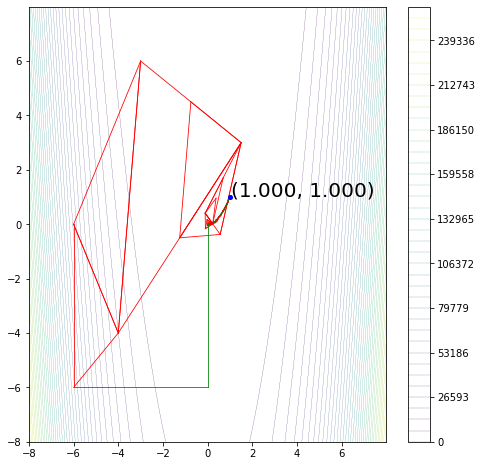

[-----------f3 results-----------]
                    minimum  point                                        iteration      time
----------------  ---------  -----------------------------------------  -----------  --------
NelderMeadMethod   -5.73452  (3.3500199895319156, -0.5435905340104432)           56  69.20600
PowellMethod       -5.73452  (3.3500164504670606, -0.5435880535201194)            4   6.23417


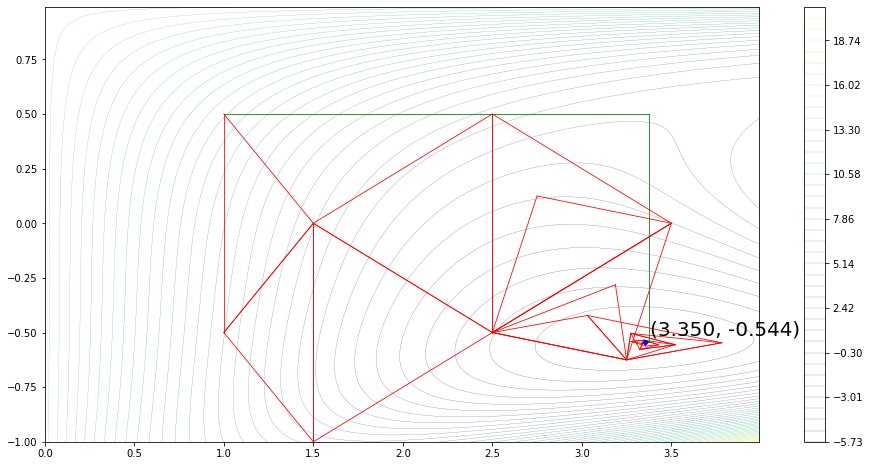

In [29]:
print("Plotting results")
print("[-----------f1 results-----------]")
simp = [(1, .2), (.2, 1), (.1, .1)]
plotContour(f_1, rangeX=(0,4), rangeY=(0,4), grid=(8,8)) 
resultsInTable(simp, f_1, terminationMode=1) 
plt.close()
print("[-----------f2 results-----------]") 
plotContour(f_2, rangeX=(-8,8), rangeY=(-8,8), grid=(8,8))
simp = [(-6, -6), (-6, 0), (-4, -4)] 
resultsInTable(simp, f_2, terminationMode=1) 
plt.show()
print("[-----------f3 results-----------]") 
plotContour(f_3, rangeX=(0,4), rangeY=(-1,1), grid=(16,8)) 
simp = [(1, 0.5), (1.5, 0), (1, -.5)]
resultsInTable(simp, f_3, terminationMode=1)
plt.show()

## Conclusion
Powell's method has much faster optimizatin than Nelder-Mead method (over 8~10times faster).

But Powell's method is highly dependent on boundary search when finding step size $\gamma$.

if the iteration of golden ration search is  10, it diverge.

termination condition 3, 4, 5 aren't implemented